# Behavioral data analysis

In [16]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
import seaborn as sns
import scipy
import statsmodels.api as sms
import statsmodels.formula.api as smf

#r stuff
import rpy2
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects import r
base = importr('base')
afex = importr('afex') 

%matplotlib inline

In [17]:
#set plotting settings
sns.set_context('paper',font_scale = 2.5)
sns.set(font="Times New Roman")
sns.set_style("white")

In [18]:
home_dir = '/Users/ianballard/Dropbox/Magnitude_fMRI/'

# Study 1: fMRI data

In [11]:
params = pd.read_csv(home_dir + '/model_fits.csv')

In [12]:
#load data
params = pd.read_csv(home_dir + '/model_fits.csv')

#log transform
for col in ['k_low','k_high','m_low','m_high']:
    params[col] = np.log(params[col])

#reformat for plotting
params_fig = pd.DataFrame({'k': list(params['k_low']) + list(params['k_high']),
              'm': list(params['m_low']) + list(params['m_high']),
             'Magnitude': ['low']*params.shape[0] + ['high']*params.shape[0],
              'sub': list(params['sub'])*2
             })

Ttest_relResult(statistic=7.9777558641033863, pvalue=1.7466756646901779e-07)
nsubs 20
r (0.44198987399263667, 0.051032362580213715)
low mean: -4.44590328802 std: 0.920111054841
high mean: -7.2906360826 std: 1.72374564085
outlier -3.38626729778


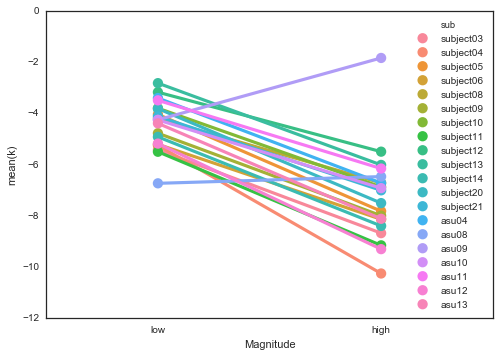

In [14]:
#compute magnitude effect and statistics
low = params['k_low']
high = params['k_high']
diff = low - high

print scipy.stats.ttest_rel(low,high)
print 'nsubs', params.shape[0]
print 'r', scipy.stats.pearsonr(high,low)
print 'low', 'mean:', np.mean(low),'std:',  np.std(low)
print 'high', 'mean:', np.mean(high),'std:', np.std(high)
print 'outlier',(min(diff) - np.mean(diff))/np.std(diff)

sns.pointplot(x="Magnitude", y="k", hue="sub", data=params_fig);

Ttest_relResult(statistic=5.7989595919784795, pvalue=1.3793223083559148e-05)
df (20, 7)
low mean: 1.73378204168 std: 1.51680032131
high mean: 0.255455410349 std: 0.513185214509


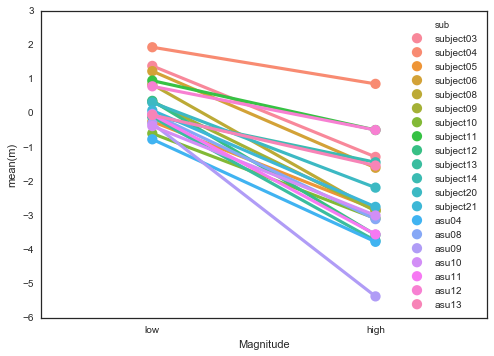

In [148]:
#compute magnitude effect and statistics
low = params['m_low']
high = params['m_high']
diff = low - high

print scipy.stats.ttest_rel(low,high)
print 'df', params.shape
print 'low', 'mean:', np.mean(low),'std:',  np.std(low)
print 'high', 'mean:', np.mean(high),'std:', np.std(high)

sns.pointplot(x="Magnitude", y="m", hue="sub", data=params_fig);

# Study 2: Hunger

(-0.28767764198930867, 0.00031128558860400875)


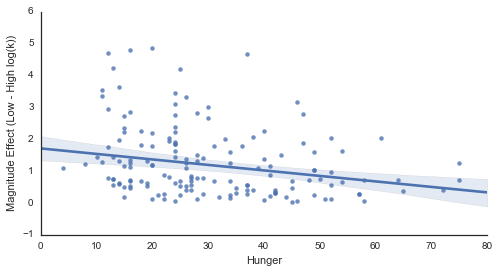

In [19]:
plt.figure(figsize=(8, 4))
hunger = pd.read_csv(home_dir + 'hunger_k_and_m.csv')
hunger = hunger.dropna()
hunger['Hunger'] = hunger['hunger']
hunger['Magnitude Effect (Low - High log(k))'] = [np.log(l) - np.log(h) for h,l in zip(hunger['k_high'],hunger['k_low'])]

ax = sns.regplot(y = 'Magnitude Effect (Low - High log(k))',x = 'Hunger',data = hunger,ci = 95,
                robust = True)
sns.despine()
print scipy.stats.pearsonr(hunger['Magnitude Effect (Low - High log(k))'],np.log(hunger['hunger']))
plt.savefig(home_dir + '/Figures/hunger_mag_corr.svg',dpi=300)

In [23]:
#compute correlations 
print hunger.shape
print 'k_high versus hunger',scipy.stats.pearsonr(np.log(hunger['k_high']),np.log(hunger['hunger']))
print 'k_low versus hunger',scipy.stats.pearsonr(np.log(hunger['k_low']),np.log(hunger['hunger']))
print 'm_high versus hunger',scipy.stats.pearsonr(np.log(hunger['m_high']),np.log(hunger['hunger']))
print 'm_low versus hunger',scipy.stats.pearsonr(np.log(hunger['m_low']),np.log(hunger['hunger']))

(153, 15)
k_high versus hunger (0.41418927788178916, 1.025071506496574e-07)
k_low versus hunger (0.24630656115671057, 0.0021471583379478756)
m_high versus hunger (-0.66582793511576654, 5.9937271328680122e-21)
m_low versus hunger (-0.66689092708083675, 4.9371075316164838e-21)


In [21]:
#compute size of magnitude effect
print hunger.shape
high = np.log(hunger['k_high'])
low = np.log(hunger['k_low'])
print 'high',np.mean(high), np.std(high)
print 'low',np.mean(low), np.std(low)
print 'r', scipy.stats.pearsonr(high,low)
diff = high - low
print scipy.stats.ttest_rel(high,low)

(153, 15)
high -6.16316149088 1.4010953368
low -4.8662435958 1.0748110811
r (0.63577820119501649, 1.0559893585242592e-18)
Ttest_relResult(statistic=-14.575489448353999, pvalue=1.1523709513930357e-30)


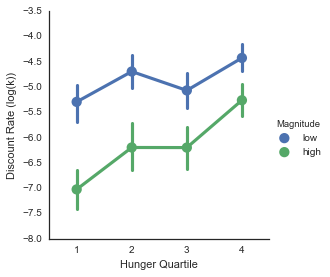

In [78]:
#plot discount rate as a function of magnitude and hunger
plt.figure(figsize=(4, 4))
df = pd.DataFrame()
df['Hunger Quartile'] = map(int,list(hunger['hungerLevel'].values)*2)
df['Discount Rate (log(k))'] = map(np.log,hunger['k_low'].values) + map(np.log,hunger['k_high'].values)
df['Magnitude'] = ['low']*len(hunger['k_low']) + ['high']*len(hunger['k_high'])

sns.factorplot(x="Hunger Quartile", y="Discount Rate (log(k))", hue="Magnitude",data=df,ci=95);

plt.savefig(home_dir + '/Figures/hunger_mag_quartiles.svg',dpi=300)

In [85]:
# aggregate means and standard deviations for each condition
std = pd.DataFrame(df.groupby(['Magnitude','Hunger Quartile']).std()['Discount Rate (log(k))'])
std = pd.DataFrame(std.to_records())
std.columns = ['Magnitude','Hunger Quartile','Std']

mean = pd.DataFrame(df.groupby(['Magnitude','Hunger Quartile']).mean()['Discount Rate (log(k))'])
mean = pd.DataFrame(mean.to_records())
mean.columns = ['Magnitude','Hunger Quartile','Mean']


results = pd.merge(mean,std, on = ['Magnitude','Hunger Quartile'])
results.to_csv(home_dir + '/Figures/hunger_data.csv',float_format='%.3f', index = False)

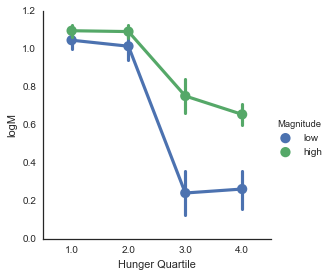

In [32]:
#plot M as a function of magnitude and hunger
plt.figure(figsize=(4, 4))
df = pd.DataFrame()
df['Hunger Quartile'] = list(hunger['hungerLevel'].values)*2
df['logM'] = map(np.log,hunger['m_low'].values) + map(np.log,hunger['m_high'].values)
df['Magnitude'] = ['low']*len(hunger['m_low']) + ['high']*len(hunger['m_high'])
sns.factorplot(x="Hunger Quartile", y="logM", hue="Magnitude", data=df, ci=95);
plt.savefig(home_dir + '/Figures/m_quartiles.svg',dpi=300)

(-0.3514143796987525, 8.4282875820250962e-06)


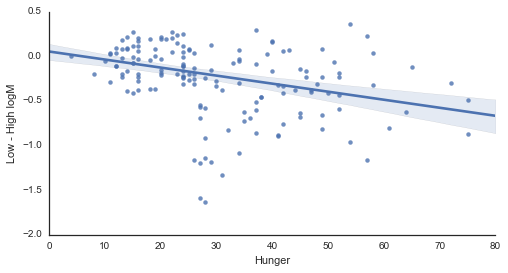

In [33]:
#plot correlation of M magnitude effect with hunger
plt.figure(figsize=(8, 4))

hunger['Low - High logM'] = [np.log(l) - np.log(h) for h,l in zip(hunger['m_high'],hunger['m_low'])]
sns.regplot(y = 'Low - High logM',x = 'Hunger',data = hunger,
            robust = True, ci=95)
sns.despine()
print scipy.stats.pearsonr(hunger['Low - High logM'],np.log(hunger['hunger']))

plt.savefig(home_dir + '/Figures/m_corr.svg',dpi=300)

In [34]:
#ANOVA on magnitude effect with k
df = pd.DataFrame()

for row in hunger.iterrows():
    new_r = {'sub':str(row[0]),
                  'k':np.log(row[1]['k_low']),
                  'mag':'low',
                 'hunger':row[1]['hungerLevel']}
    df = df.append(pd.DataFrame.from_dict({0: new_r}, orient='index'))
    
    new_r = {'sub':str(row[0]),
                  'k':np.log(row[1]['k_high']),
                  'mag':'high',
                 'hunger':row[1]['hungerLevel']}
    df = df.append(pd.DataFrame.from_dict({0: new_r}, orient='index'))

model = afex.aov_ez('sub', 'k', data = df, within=['mag'],between='hunger')
print(model)
print model.rx2('Anova')

Anova Table (Type 3 tests)

Response: k
      Effect     df  MSE          F ges p.value
1     hunger 3, 149 2.13  10.69 *** .15  <.0001
2        mag 1, 149 0.56 231.99 *** .24  <.0001
3 hunger:mag 3, 149 0.56    5.41 ** .02    .001

Sphericity correction method: GG 


Type III Repeated Measures MANOVA Tests: Pillai test statistic
            Df test stat approx F num Df den Df    Pr(>F)    
(Intercept)  1   0.96712   4382.5      1    149 < 2.2e-16 ***
hunger       3   0.17706     10.7      3    149 2.101e-06 ***
mag          1   0.60891    232.0      1    149 < 2.2e-16 ***
hunger:mag   3   0.09824      5.4      3    149  0.001463 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



In [35]:
#ANOVA on magnitude effect with m
df = pd.DataFrame()

for row in hunger.iterrows():
    new_r = {'sub':str(row[0]),
                  'm':np.log(row[1]['m_low']),
                  'mag':'low',
                 'hunger':row[1]['hungerLevel']}
    df = df.append(pd.DataFrame.from_dict({0: new_r}, orient='index'))
    
    new_r = {'sub':str(row[0]),
                  'm':np.log(row[1]['m_high']),
                  'mag':'high',
                 'hunger':row[1]['hungerLevel']}
    df = df.append(pd.DataFrame.from_dict({0: new_r}, orient='index'))

model = afex.aov_ez('sub', 'm', data = df, within=['mag'],between='hunger')
# lsm  = importr('lsmeans')
# pairwise = lsm.lsmeans(model, "mag", contr="pairwise", adjust="holm")
print model
print model.rx2('Anova')

Anova Table (Type 3 tests)

Response: m
      Effect     df  MSE          F ges p.value
1     hunger 3, 149 0.05 165.32 *** .61  <.0001
2        mag 1, 149 0.06  86.62 *** .23  <.0001
3 hunger:mag 3, 149 0.06  17.14 *** .15  <.0001

Sphericity correction method: GG 


Type III Repeated Measures MANOVA Tests: Pillai test statistic
            Df test stat approx F num Df den Df    Pr(>F)    
(Intercept)  1   0.95836   3429.6      1    149 < 2.2e-16 ***
hunger       3   0.76897    165.3      3    149 < 2.2e-16 ***
mag          1   0.36763     86.6      1    149 < 2.2e-16 ***
hunger:mag   3   0.25653     17.1      3    149 1.295e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



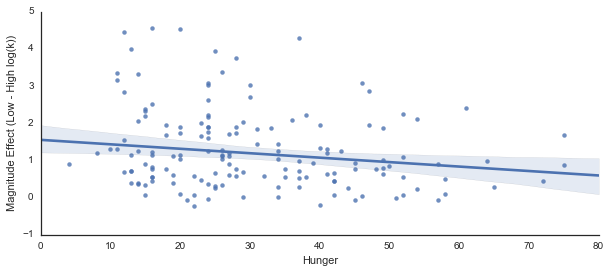

In [36]:
# plot k with mag partialled out
plt.figure(figsize=(10, 4))
ax = sns.regplot(y = 'Magnitude Effect (Low - High log(k))',x = 'Hunger',data = hunger,
                robust = True, y_partial = 'Low - High logM',ci=95)
sns.despine()
plt.savefig(home_dir + '/Figures/hunger_mag_corr_partial.svg',dpi=300)


In [38]:
#analyze relation with BMI
hunger['bmi'] = [w * 1.0/(h**2) for w,h in zip(hunger['body weight'],hunger['height(m)'])]
print scipy.stats.pearsonr(hunger['Magnitude Effect (Low - High log(k))'],hunger['bmi'])

(0.036259336854528541, 0.65634034070289449)


In [39]:
# Fit regression model of k and m on hunger
hunger['K_low_minus_high'] = hunger['Magnitude Effect (Low - High log(k))']
hunger['M_low_minus_high'] = hunger['Low - High logM']
hunger['logHunger'] = np.log(hunger['hunger'])
results = smf.ols('logHunger ~ K_low_minus_high + M_low_minus_high', data=hunger).fit()

# Inspect the results
print results.summary()

                            OLS Regression Results                            
Dep. Variable:              logHunger   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     14.99
Date:                Thu, 13 Apr 2017   Prob (F-statistic):           1.17e-06
Time:                        06:16:22   Log-Likelihood:                -102.06
No. Observations:                 153   AIC:                             210.1
Df Residuals:                     150   BIC:                             219.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept            3.3178      0.071  

In [ ]:
#compute partial correlation
results = smf.ols('logHunger ~ M_low_minus_high', data=hunger).fit()
print scipy.stats.pearsonr(results.resid, hunger['K_low_minus_high'])
print hunger.shape

# Study 3: Justify

In [40]:
justify = pd.read_csv(home_dir + 'justify.csv')
justify = justify.drop('Income', 1)
justify = justify.drop('d', 1)
justify = justify.drop('1-d', 1)
justify = justify.drop('log(1-d) ', 1)
justify = justify.drop('log(d)', 1)
justify = justify.drop('Unnamed: 15', 1)
justify = justify.drop('Word Count', 1)

justify.to_csv(home_dir + 'justify_clean.csv', index = False)
print justify.shape

(1382, 9)


In [41]:
#make coding more explicit
cond_map = {'1':20,'2':20,
           '3':50,'4':50,
           '5':100,'6':100,
           '7':200,'8':200,
           '9':2000,'10':2000}
manip_map = {1:'No Justification',2:'Justification'}
justify['Offer'] = [cond_map[str(x)] for x in justify['Condition']]
justify['Condition'] = [manip_map[x] for x in justify['Manipulation']]

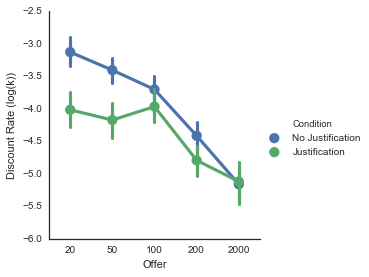

In [42]:
#plot justify results
plt.figure(figsize=(4, 4))
justify['Discount Rate (log(k))'] = map(np.log,(justify['Choice'] / justify['Offer'] - 1)/30.0)
sns.factorplot(x="Offer", y="Discount Rate (log(k))", hue="Condition", data=justify, ci=95);
sns.despine()
plt.savefig(home_dir + '/Figures/justify.svg',dpi=300)

In [43]:
justify['logK'] = justify['Discount Rate (log(k))']
justify['sub'] = justify['Subject ID']
model = afex.aov_ez('sub', 'logK', data = justify, between=['Manipulation','Magnitude'])
print model
print model.rx2('Anova')

//anaconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Converting to factor: Manipulation, Magnitude

  warnings.warn(x, RRuntimeWarning)
//anaconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Contrasts set to contr.sum for the following variables: Manipulation, Magnitude

  warnings.warn(x, RRuntimeWarning)


Anova Table (Type 3 tests)

Response: logK
                  Effect      df  MSE         F ges p.value
1           Manipulation 1, 1372 2.03 33.88 *** .02  <.0001
2              Magnitude 4, 1372 2.03 57.03 *** .14  <.0001
3 Manipulation:Magnitude 4, 1372 2.03  4.68 *** .01   .0009

Anova Table (Type III tests)

Response: dv
                        Sum Sq   Df   F value    Pr(>F)    
(Intercept)            23760.0    1 11693.858 < 2.2e-16 ***
Manipulation              68.8    1    33.882 7.283e-09 ***
Magnitude                463.5    4    57.030 < 2.2e-16 ***
Manipulation:Magnitude    38.0    4     4.678 0.0009421 ***
Residuals               2787.7 1372                        
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



In [75]:
# aggregate means and standard deviations for each condition
std = pd.DataFrame(justify.groupby(['Condition','Offer']).std()['Discount Rate (log(k))'])
std = pd.DataFrame(std.to_records())
std.columns = ['Condition','Offer','Std']

mean = pd.DataFrame(justify.groupby(['Condition','Offer']).mean()['Discount Rate (log(k))'])
mean = pd.DataFrame(mean.to_records())
mean.columns = ['Condition','Offer','Mean']

results = pd.merge(mean,std, on = ['Condition','Offer'])
results.to_csv(home_dir + '/Figures/justify_data.csv',float_format='%.3f', index = False)